In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# For preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# For modeling
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# For saving the model
import pickle

In [9]:
def calculate_aqi_subindex(value, breakpoints):
    for (low, high, sub_low, sub_high) in breakpoints:
        if low <= value <= high:
            return ((sub_high - sub_low) / (high - low)) * (value - low) + sub_low
    return None

In [10]:
# Define AQI breakpoints for pollutants
aqi_breakpoints = {
    "PM2.5": [(0, 30, 0, 50), (31, 60, 51, 100), (61, 90, 101, 200), 
              (91, 120, 201, 300), (121, 250, 301, 400), (251, 500, 401, 500)],
    "PM10": [(0, 50, 0, 50), (51, 100, 51, 100), (101, 250, 101, 200), 
             (251, 350, 201, 300), (351, 430, 301, 400), (431, 600, 401, 500)],
    "NO2": [(0, 40, 0, 50), (41, 80, 51, 100), (81, 180, 101, 200), 
            (181, 280, 201, 300), (281, 400, 301, 400), (401, 1000, 401, 500)]
}

In [14]:
def compute_daily_aqi(df):
    df = df.copy()
    df["From Date"] = pd.to_datetime(df["From Date"])
    df["Date"] = df["From Date"].dt.date
    
    for pollutant, breakpoints in aqi_breakpoints.items():
        df[pollutant + "_AQI"] = df[pollutant].apply(lambda x: calculate_aqi_subindex(x, breakpoints))
    
    daily_aqi = df.groupby("Date")[["PM2.5_AQI", "PM10_AQI", "NO2_AQI"]].max()
    daily_aqi["AQI"] = daily_aqi.max(axis=1)
    return daily_aqi.reset_index()

In [16]:
datasets = {
    "BandraKurlaComplex": pd.read_csv("BandraKurlaComplexMumbaiIITM.csv"),
    "Kurla": pd.read_csv("KurlaMumbaiMPCB.csv"),
    "Colaba": pd.read_csv("ColabaMumbaiMPCB.csv")
}

daily_datasets = {name: compute_daily_aqi(df) for name, df in datasets.items()}

In [17]:
for name in daily_datasets:
    daily_datasets[name] = daily_datasets[name].interpolate(method="linear").fillna(method="bfill")

# Combine datasets
full_data = pd.concat(daily_datasets.values())

def create_lag_features(df, lags=[1, 2, 3]):
    df = df.copy()
    for lag in lags:
        df[f"AQI_Lag{lag}"] = df["AQI"].shift(lag)
    df.dropna(inplace=True)
    return df

full_data = create_lag_features(full_data)

C:\Users\Vinit Solanki\AppData\Local\Temp\ipykernel_8292\3680661542.py:2: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  daily_datasets[name] = daily_datasets[name].interpolate(method="linear").fillna(method="bfill")
C:\Users\Vinit Solanki\AppData\Local\Temp\ipykernel_8292\3680661542.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily_datasets[name] = daily_datasets[name].interpolate(method="linear").fillna(method="bfill")
C:\Users\Vinit Solanki\AppData\Local\Temp\ipykernel_8292\3680661542.py:2: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  daily_datasets[name] = daily_datasets[name].interpolate(method="linear").fillna(method="bfill")
C:\Users

In [23]:
X = full_data.drop(columns=["Date", "AQI"])
y = full_data["AQI"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train XGBoost model
import xgboost as xgb

xgb_model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.1, max_depth=5)
xgb_model.fit(X_train_scaled, y_train)

# Evaluate model
train_score = xgb_model.score(X_train_scaled, y_train)
test_score = xgb_model.score(X_test_scaled, y_test)
print(f"Training Score: {train_score:.2%}")
print(f"Testing Score: {test_score:.2%}")

Training Score: 99.59%
Testing Score: 95.59%


In [27]:
y_pred = xgb_model.predict(X_test_scaled)

In [28]:
latest_data = X.iloc[-1:].values  # Get the latest available data point
latest_data_scaled = scaler.transform(latest_data)
predicted_aqi = xgb_model.predict(latest_data_scaled)[0]
print(f"Predicted AQI for next day: {predicted_aqi:.2f}")

Predicted AQI for next day: 208.15


c:\Users\Vinit Solanki\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


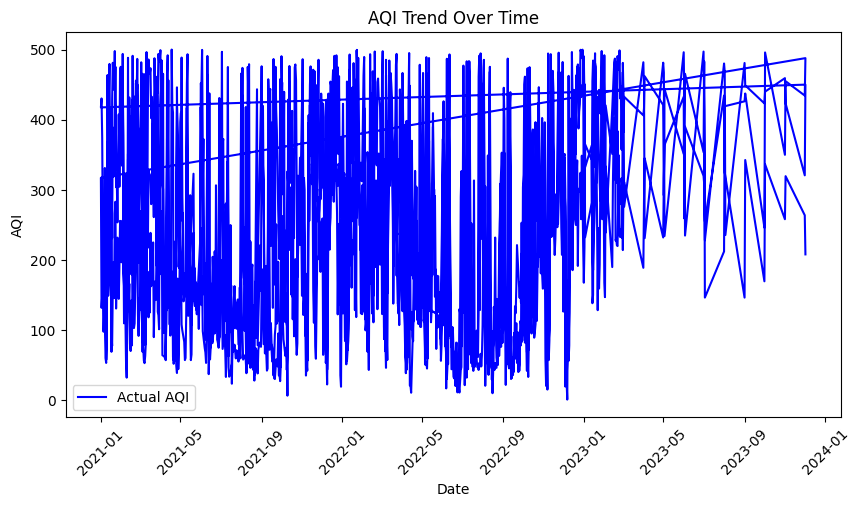

In [29]:
plt.figure(figsize=(10, 5))
plt.plot(full_data["Date"], full_data["AQI"], label="Actual AQI", color="blue")
plt.xlabel("Date")
plt.ylabel("AQI")
plt.legend()
plt.title("AQI Trend Over Time")
plt.xticks(rotation=45)
plt.show()

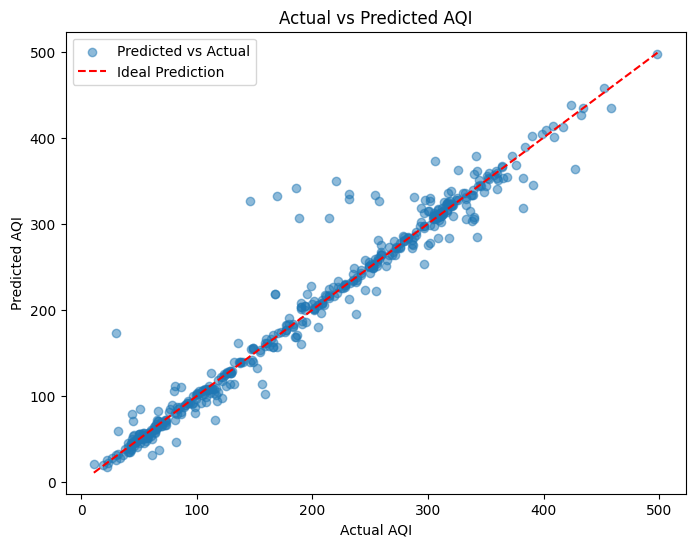

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label="Predicted vs Actual")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--", label="Ideal Prediction")
plt.xlabel("Actual AQI")
plt.ylabel("Predicted AQI")
plt.legend()
plt.title("Actual vs Predicted AQI")
plt.show()

In [31]:
from sklearn.metrics import r2_score

y_pred = xgb_model.predict(X_test_scaled)
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.2f}")

R² Score: 0.96


In [32]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

Mean Absolute Error (MAE): 10.42


In [34]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Mean Squared Error (MSE): 538.99
Root Mean Squared Error (RMSE): 23.22


In [35]:
import pickle
import xgboost
from sklearn.preprocessing import StandardScaler

# Train XGBoost Model (Ensure it's already trained)
xgb_model = xgboost.XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.1, max_depth=5)
xgb_model.fit(X_train_scaled, y_train)

# Save the model
with open("xgboost_aqi_model.pkl", "wb") as model_file:
    pickle.dump(xgb_model, model_file)

# Save the scaler
with open("scaler.pkl", "wb") as scaler_file:
    pickle.dump(scaler, scaler_file)

print("Model and Scaler saved successfully!")

Model and Scaler saved successfully!
